In [1]:
import numpy as np
import pandas as pd
import json
from math import radians, cos, sin, asin, sqrt
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train= pd.read_csv('train_final.txt')
test = pd.read_csv('test_final.txt')

In [4]:
train = train.drop([ 'Unnamed: 0'], axis = 1)
test  = test.drop([ 'Unnamed: 0'], axis = 1)

In [5]:
print('train_shape:', train.shape, '\n', 'test_shape:', test.shape)

train_shape: (1704769, 16) 
 test_shape: (320, 16)


In [6]:
train.head(2)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,duration,start,destination,haversine,date_H,date_D,date_M,date_Y,date_W
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",330,"[-8.618643, 41.141412]","[-8.630838, 41.154489]",1776.807571,8,1,7,2013,Monday
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",270,"[-8.639847, 41.159826]","[-8.66574, 41.170671]",2480.360461,8,1,7,2013,Monday


In [7]:
test.head(2)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,duration,start,destination,haversine,date_H,date_D,date_M,date_Y,date_W
0,T1,B,NaN,15.0,20000542,1408039037,"[[-8.585676, 41.148522], [-8.585712, 41.148639...",150,"[-8.585676, 41.148522]","[-8.584884, 41.146623]",221.327676,1,15,8,2014,Friday
1,T2,B,NaN,57.0,20000108,1408038611,"[[-8.610876, 41.14557], [-8.610858, 41.145579]...",585,"[-8.610876, 41.14557]","[-8.601894, 41.163597]",2140.926138,1,15,8,2014,Friday


# K-means

In [8]:
train['start'] = train['start'].apply(json.loads)
train['destination'] = train['destination'].apply(json.loads)
test['start'] = test['start'].apply(json.loads)
test['destination'] = test['destination'].apply(json.loads)

In [9]:
test_means = pd.DataFrame()
start_X = []
start_Y = []
destination_X = [] 
destination_Y = []
for i in range(test.shape[0]):
    start_X.append(test.start[i][0])
    start_Y.append(test.start[i][1])
    destination_X.append(test.destination[i][0])
    destination_Y.append(test.destination[i][1])
test_means['start_X'] = start_X
test_means['start_Y'] = start_Y
test_means['destination_X'] = destination_X
test_means['destination_Y'] = destination_Y

In [10]:
train_means = pd.DataFrame()
start_X = []
start_Y = []
destination_X = [] 
destination_Y = []
for i in range(train.shape[0]):
    start_X.append(train.start[i][0])
    start_Y.append(train.start[i][1])
    destination_X.append(train.destination[i][0])
    destination_Y.append(train.destination[i][1])
train_means['start_X'] = start_X
train_means['start_Y'] = start_Y
train_means['destination_X'] = destination_X
train_means['destination_Y'] = destination_Y

In [11]:
train_id = train[['TRIP_ID']]
test_id = test[['TRIP_ID']]

In [12]:
train_means = pd.concat([train_id, train_means], axis = 1)
test_means = pd.concat([test_id, test_means], axis = 1)

In [13]:
XXX = start_X + destination_X
YYY = start_Y + destination_Y

In [14]:
iii = pd.DataFrame()
iii['X'] = XXX
iii['Y'] = YYY

In [15]:
iii.shape

(3409538, 2)

In [17]:
%matplotlib qt

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(iii.X, iii.Y,s = 5, c= 'r')
plt.title('All point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [20]:
low = .05
high = .95
quant_iii = iii.quantile([low, high])

In [21]:
quant_iii

,X,Y
0.05,-8.671203,41.140827
0.95,-8.579943,41.187636


In [22]:
filt_iii = iii.apply(lambda x: x[(x>quant_iii.loc[low,x.name]) &  (x < quant_iii.loc[high,x.name])], axis=0)

In [23]:
good_iii = filt_iii.dropna()

In [24]:
iii.shape

(3409538, 2)

In [25]:
good_iii.shape

(2792937, 2)

In [21]:
%matplotlib inline

In [26]:
plt.figure(figsize=(20,10))
plt.scatter(good_iii.X, good_iii.Y, c= 'r', s = 0.5)
plt.title('All point without outlier')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [32]:
from sklearn.cluster import KMeans

In [33]:
Xs = good_iii.iloc[:, 0:3].values

In [34]:
len(Xs)

2792937

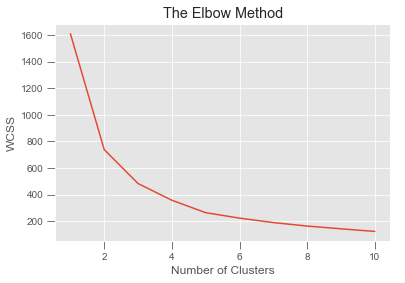

In [178]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 889)
    kmeans.fit(Xs)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [35]:
kmeans = KMeans(n_clusters = 11, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)

In [36]:
y_kmeans = kmeans.fit_predict(Xs)

In [27]:
len(y_kmeans)

2792937

In [37]:
plt.figure(figsize=(20,10))
plt.scatter(Xs[y_kmeans == 0, 0], Xs[y_kmeans == 0, 1],s = 0.5, c = 'darkorchid', label = 'S1')
plt.scatter(Xs[y_kmeans == 0, 0], Xs[y_kmeans == 0, 1],s = 0.5, c = 'darkorchid', label = 'S1')
plt.scatter(Xs[y_kmeans == 1, 0], Xs[y_kmeans == 1, 1],s = 0.5, c = 'blue', label = 'S2')
plt.scatter(Xs[y_kmeans == 2, 0], Xs[y_kmeans == 2, 1],s = 0.5, c = 'green', label = 'S3')
plt.scatter(Xs[y_kmeans == 3, 0], Xs[y_kmeans == 3, 1],s = 0.5, c = 'chocolate', label = 'S4')
plt.scatter(Xs[y_kmeans == 4, 0], Xs[y_kmeans == 4, 1],s = 0.5, c = 'magenta', label = 'S5')
plt.scatter(Xs[y_kmeans == 5, 0], Xs[y_kmeans == 5, 1],s = 0.5, c = 'red', label = 'S6')
plt.scatter(Xs[y_kmeans == 6, 0], Xs[y_kmeans == 6, 1],s = 0.5, c = 'lime', label = 'S7')
plt.scatter(Xs[y_kmeans == 7, 0], Xs[y_kmeans == 7, 1],s = 0.5, c = 'purple', label = 'S8')
plt.scatter(Xs[y_kmeans == 8, 0], Xs[y_kmeans == 8, 1],s = 0.5, c = 'goldenrod', label = 'S9')
plt.scatter(Xs[y_kmeans == 9, 0], Xs[y_kmeans == 9, 1],s = 0.5, c = 'sienna', label = 'S10')
plt.scatter(Xs[y_kmeans == 10, 0], Xs[y_kmeans == 10, 1],s = 0.5, c = 'steelblue', label = 'S11')
plt.scatter(kmeans.cluster_centers_[:, 0],  kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('All point without outlier')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.legend(fontsize=5, loc = 1)
plt.show()

In [28]:
print(good_iii.shape)
print(len(y_kmeans))

(2792937, 2)
2792937


In [29]:
good_iii['K'] = y_kmeans 

In [30]:
good_iii.head()

,X,Y,K
0,-8.618643,41.141412,7
1,-8.639847,41.159826,1
4,-8.645994,41.180490,6
7,-8.617563,41.146182,7
10,-8.619894,41.148009,7


# k-nn

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [32]:
X = good_iii.iloc[:,0:2].values
y = good_iii.iloc[:,-1:].values

In [33]:
train_data , test_data , train_label , test_label = train_test_split(X,y,test_size=0.2)

In [34]:
knn = KNeighborsClassifier()
knn.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
print(knn.predict(test_data))

[2 7 6 ... 8 6 4]


In [35]:
print(train_means.shape)
print(test_means.shape)

(1704769, 5)
(320, 5)


In [36]:
train_start = train_means[['TRIP_ID', 'start_X', 'start_Y']]

In [37]:
train_destination = train_means[['TRIP_ID', 'destination_X', 'destination_Y']]

In [38]:
test_start = test_means[['TRIP_ID', 'start_X', 'start_Y']]

In [39]:
test_destination = test_means[['TRIP_ID', 'destination_X', 'destination_Y']]

In [40]:
print('train_start', train_start.shape)
print('train_destination', train_destination.shape)
print('test_start', test_start.shape)
print('test_destination', test_destination.shape)

train_start (1704769, 3)
train_destination (1704769, 3)
test_start (320, 3)
test_destination (320, 3)


In [41]:
trainS = train_start.iloc[:, 1:3].values
trainD = train_destination.iloc[:, 1:3].values
testS = test_start.iloc[:, 1:3].values
testD = test_destination.iloc[:, 1:3].values

In [42]:
test_start['start point'] = knn.predict(testS)

In [43]:
test_destination['destination point'] = knn.predict(testD)

In [52]:
test_destination = test_destination.drop('TRIP_ID', axis = 1)

In [44]:
train_start['start point'] = knn.predict(trainS)

In [45]:
train_destination['destination point'] = knn.predict(trainD)

In [51]:
train_destination = train_destination.drop('TRIP_ID', axis = 1)

In [53]:
train_k = pd.concat([train_start, train_destination], axis = 1)

In [55]:
test_k = pd.concat([test_start, test_destination], axis = 1)

In [57]:
train_k.to_csv(r'train_k.txt')
test_k.to_csv(r'test_k.txt')

In [56]:
test_k.head()

,TRIP_ID,start_X,start_Y,start point,destination_X,destination_Y,destination point
0,T1,-8.585676,41.148522,0,-8.584884,41.146623,0
1,T2,-8.610876,41.145570,2,-8.601894,41.163597,8
2,T3,-8.585739,41.148558,0,-8.574903,41.167719,5
3,T4,-8.613963,41.141169,7,-8.614638,41.140980,7
4,T5,-8.619903,41.148036,7,-8.619894,41.148036,7


In [103]:
test_start.head()

,TRIP_ID,start_X,start_Y,start point
0,T1,-8.585676,41.148522,0
1,T2,-8.610876,41.145570,2
2,T3,-8.585739,41.148558,0
3,T4,-8.613963,41.141169,7
4,T5,-8.619903,41.148036,7


In [56]:
quant_iii

,X,Y
0.05,-8.671203,41.140827
0.95,-8.579943,41.187636


In [102]:
for i in range(test_start.shape[0]):
    if (test_start['start_X'][i] > -8.579943 or test_start['start_X'][i] < -8.671203) or (test_start['start_Y'][0] > 41.187636 or test_start['start_Y'][i] < 41.140827):
        test_start['start point'][i] = 11   

In [104]:
for i in range(test_destination.shape[0]):
    if (test_destination['destination_X'][i] > -8.579943 or test_destination['destination_X'][i] < -8.671203) or (test_destination['destination_Y'][0] > 41.187636 or test_destination['destination_Y'][i] < 41.140827):
        test_destination['destination point'][i] = 11   

In [ ]:
for i in range(train_start.shape[0]):
    if (train_start['start_X'][i] > -8.579943 or train_start['start_X'][i] < -8.671203) or (train_start['start_Y'][0] > 41.187636 or train_start['start_Y'][i] < 41.140827):
        train_start['start point'][i] = 11  

In [ ]:
for i in range(train_destination.shape[0]):
    if (train_destination['destination_X'][i] > -8.579943 or train_destination['destination_X'][i] < -8.671203) or (train_destination['destination_Y'][0] > 41.187636 or train_destination['destination_Y'][i] < 41.140827):
        train_destination['destination point'][i] = 11   

In [76]:
quant_iii

,X,Y
0.05,-8.671203,41.140827
0.95,-8.579943,41.187636


In [88]:
test_start[test_start['start point'] == 11]

,TRIP_ID,start_X,start_Y,k,start point
15,T16,-8.618373,41.136003,11,11
21,T22,-8.612757,41.137722,11,11
33,T34,-8.567478,41.174568,11,11
34,T35,-8.579853,41.161869,11,11
35,T36,-8.689203,41.173407,11,11
39,T40,-8.615529,41.140692,11,11
61,T62,-8.574696,41.142708,11,11
68,T69,-8.613972,41.134086,11,11
83,T84,-8.564283,41.158665,11,11
113,T119,-8.574408,41.165217,11,11


# wwww

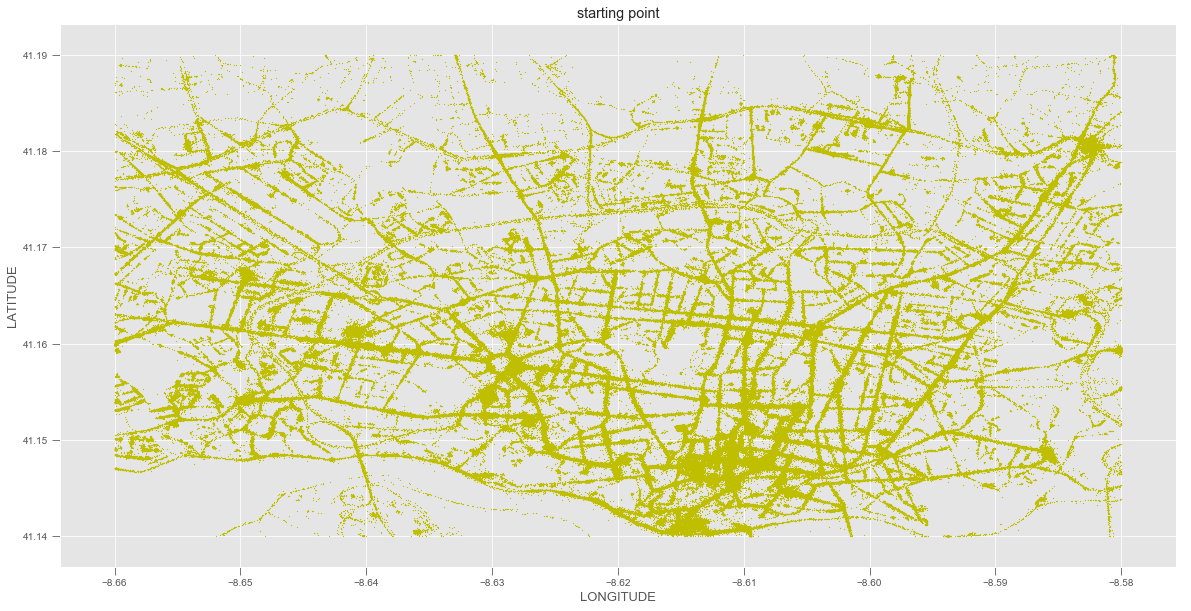

In [198]:
plt.figure(figsize=(20,10))
plt.scatter(train_start1.start_X, train_start1.start_Y,s = 0.5, c= 'y')
plt.title('starting point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [ ]:
train_start[]

In [199]:
tns = train_start1.iloc[:, 1:3].values

In [15]:
train_means.head(2)

,start_X,start_Y,destination_X,destination_Y
0,-8.618643,41.141412,-8.630838,41.154489
1,-8.639847,41.159826,-8.665740,41.170671


In [17]:
test_means.head(2)

,start_X,start_Y,destination_X,destination_Y
0,-8.585676,41.148522,-8.584884,41.146623
1,-8.610876,41.145570,-8.601894,41.163597


In [18]:
print('train_means_shape:', train_means.shape, '\n', 'test_means_shape:', test_means.shape)

train_means_shape: (1704769, 4) 
 test_means_shape: (320, 4)


In [20]:
print('train_id_shape:', train_id.shape, '\n', 'test_id_shape:', test_id.shape)

train_id_shape: (1704769, 1) 
 test_id_shape: (320, 1)


In [32]:
train_means.head(2)

,TRIP_ID,start_X,start_Y,destination_X,destination_Y
0,1372636858620000589,-8.618643,41.141412,-8.630838,41.154489
1,1372637303620000596,-8.639847,41.159826,-8.665740,41.170671


## start

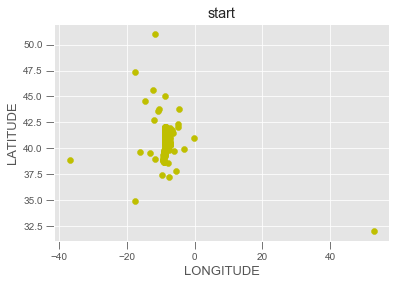

In [35]:
plt.figure(figsize=(20,10))
plt.scatter(start1.start_X, start1.start_Y, c= 'y')
plt.title('starting point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [48]:
start2 = start2[(start2['start_X'] < -8.5) & (start2['start_X'] > -8.7)]

In [47]:
start2 = start2[(start2['start_Y'] < 41.25) & (start2['start_Y'] > 41.075)]

In [54]:
start2.shape

(1702040, 3)

In [95]:
%matplotlib qt

In [103]:
plt.figure(figsize=(20,10))
plt.scatter(start2.start_X, start2.start_Y,s = 0.5,  c= 'r')
plt.title('train starting point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [51]:
from sklearn.cluster import KMeans

In [52]:
Xs = start2.iloc[:, 1:3].values

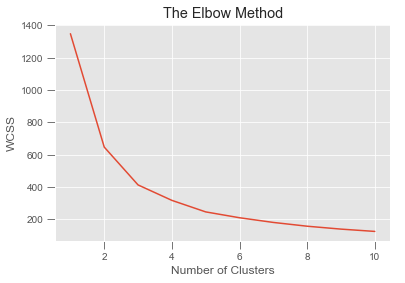

In [55]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 889)
    kmeans.fit(Xs)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [111]:
kmeans = KMeans(n_clusters = 7, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(Xs)

In [113]:
plt.figure(figsize=(20,10))
plt.scatter(Xs[y_kmeans == 0, 0], Xs[y_kmeans == 0, 1],s = 0.5, c = 'darkorchid', label = 'S1')
plt.scatter(Xs[y_kmeans == 1, 0], Xs[y_kmeans == 1, 1],s = 0.5, c = 'blue', label = 'S2')
plt.scatter(Xs[y_kmeans == 2, 0], Xs[y_kmeans == 2, 1],s = 0.5, c = 'green', label = 'S3')
plt.scatter(Xs[y_kmeans == 3, 0], Xs[y_kmeans == 3, 1],s = 0.5, c = 'chocolate', label = 'S4')
plt.scatter(Xs[y_kmeans == 4, 0], Xs[y_kmeans == 4, 1],s = 0.5, c = 'magenta', label = 'S5')
plt.scatter(Xs[y_kmeans == 5, 0], Xs[y_kmeans == 5, 1],s = 0.5, c = 'red', label = 'S6')
plt.scatter(Xs[y_kmeans == 6, 0], Xs[y_kmeans == 6, 1],s = 0.5, c = 'lime', label = 'S7')
plt.scatter(kmeans.cluster_centers_[:, 0],  kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('train starting point')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.legend(fontsize=20, loc = 1)
plt.show()

In [58]:
len(y_kmeans)

1702040

In [106]:
plt.figure(figsize=(20,10))
plt.scatter(test_start.start_X, test_start.start_Y,s = 10, c= 'r')
plt.title('test starting point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [69]:
ys = test_start.iloc[:, 1:3].values

In [114]:
yy_kmeans = kmeans.fit_predict(ys)

In [118]:
plt.figure(figsize=(20,10))
plt.scatter(ys[yy_kmeans == 0, 0], ys[yy_kmeans == 0, 1],s = 10, c = 'gold', label = 'S1')
plt.scatter(ys[yy_kmeans == 1, 0], ys[yy_kmeans == 1, 1],s = 10, c = 'blue', label = 'S2')
plt.scatter(ys[yy_kmeans == 2, 0], ys[yy_kmeans == 2, 1],s = 10, c = 'green', label = 'S3')
plt.scatter(ys[yy_kmeans == 3, 0], ys[yy_kmeans == 3, 1],s = 10, c = 'chocolate', label = 'S4')
plt.scatter(ys[yy_kmeans == 4, 0], ys[yy_kmeans == 4, 1],s = 10, c = 'magenta', label = 'S5')
plt.scatter(ys[yy_kmeans == 5, 0], ys[yy_kmeans == 5, 1],s = 0.5, c = 'red', label = 'S6')
plt.scatter(ys[yy_kmeans == 6, 0], ys[yy_kmeans == 6, 1],s = 0.5, c = 'lime', label = 'S7')
plt.scatter(kmeans.cluster_centers_[:, 0],  kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('test starting point')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.legend(fontsize=20)
plt.show()

In [119]:
yy_kmeans

array([5, 0, 5, 0, 0, 6, 5, 2, 0, 5, 5, 5, 5, 4, 1, 0, 6, 0, 5, 1, 5, 0,
       6, 5, 6, 3, 5, 5, 6, 5, 5, 0, 0, 2, 5, 4, 6, 0, 5, 0, 0, 2, 5, 0,
       6, 0, 1, 1, 5, 5, 6, 0, 0, 5, 5, 0, 0, 1, 3, 6, 5, 5, 2, 3, 0, 0,
       5, 0, 0, 6, 3, 1, 5, 1, 1, 6, 0, 1, 3, 1, 0, 6, 6, 2, 6, 3, 0, 5,
       6, 4, 0, 0, 6, 0, 0, 0, 1, 3, 0, 0, 6, 3, 6, 0, 0, 1, 0, 3, 3, 6,
       3, 3, 3, 2, 6, 0, 1, 2, 3, 1, 1, 1, 3, 6, 0, 2, 0, 1, 3, 0, 0, 1,
       0, 2, 2, 5, 5, 1, 6, 0, 1, 0, 2, 5, 0, 1, 6, 6, 3, 1, 2, 0, 6, 1,
       6, 6, 0, 6, 0, 5, 3, 2, 6, 1, 0, 0, 5, 1, 0, 0, 1, 3, 0, 6, 0, 3,
       0, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 1, 1, 0, 3, 0, 5,
       5, 1, 3, 6, 1, 0, 5, 5, 0, 0, 5, 0, 0, 0, 2, 0, 6, 6, 2, 0, 6, 5,
       0, 4, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0,
       0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0,
       4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4, 5, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 6, 4, 5, 0, 0, 3, 6, 0, 6, 0, 5,

In [120]:
test_means['start'] = yy_kmeans

In [123]:
start2['start'] = y_kmeans

## destination

In [126]:
%matplotlib inline

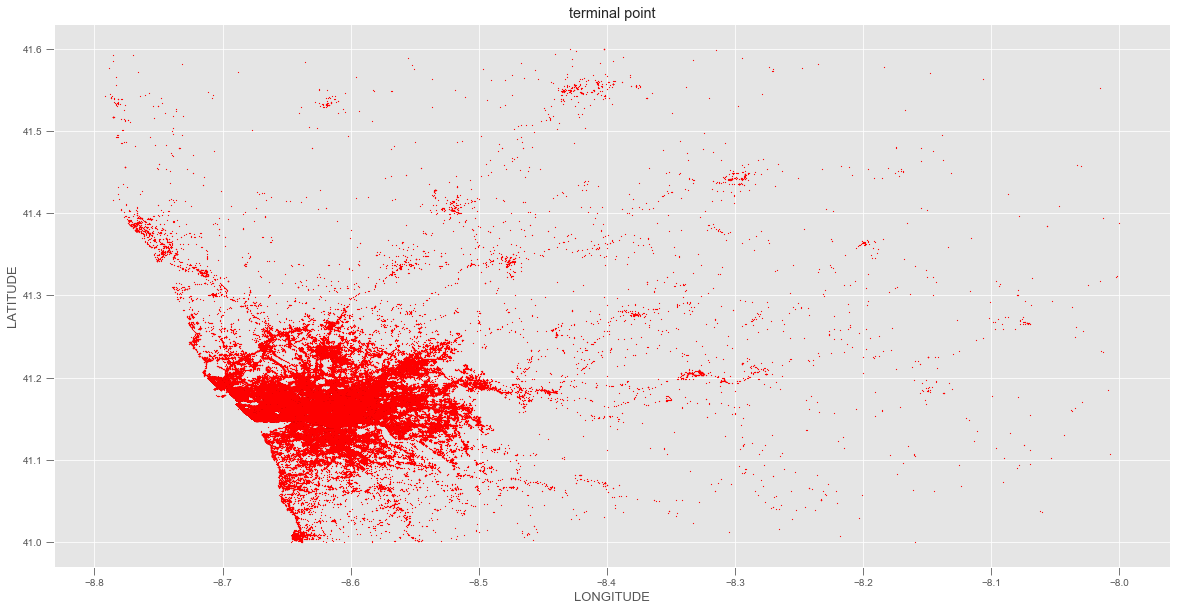

In [137]:
plt.figure(figsize=(20,10))
plt.scatter(destination2.destination_X, destination2.destination_Y,s = 0.5,  c= 'r')
plt.title('terminal point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [134]:
destination2 = destination1[(destination1['destination_X'] < -8) & (destination1['destination_X'] > -8.8)]

In [135]:
destination2 = destination2[(destination2['destination_Y'] < 41.6) & (destination2['destination_Y'] > 41)]

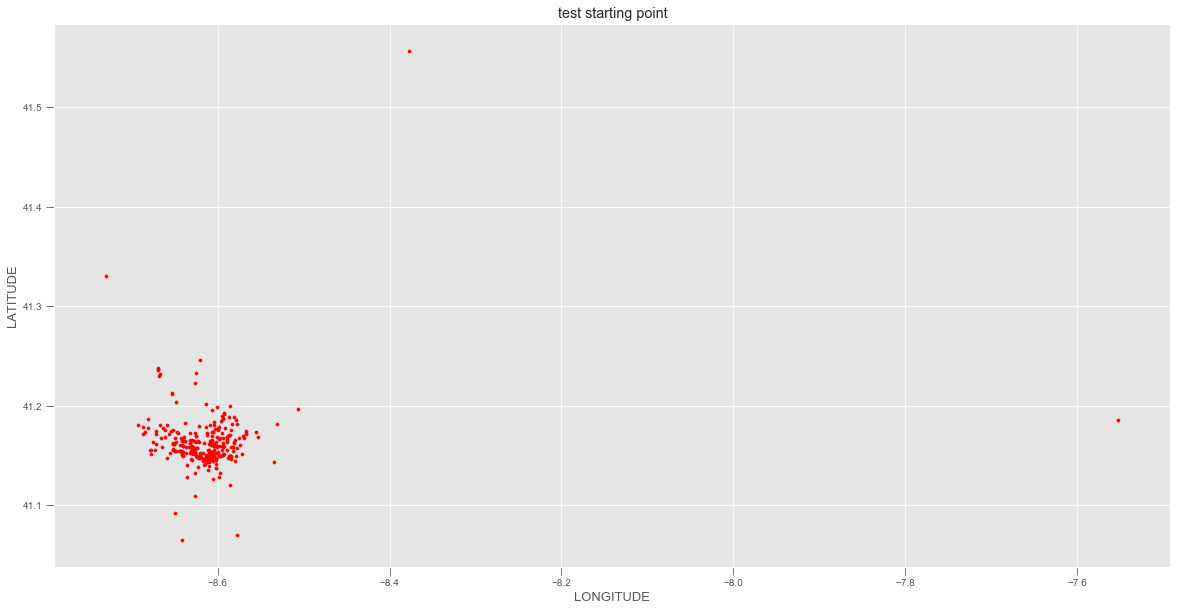

In [128]:
plt.figure(figsize=(20,10))
plt.scatter(test_destination.destination_X, test_destination.destination_Y,s = 10, c= 'r')
plt.title('test terminal point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()